# Imports

In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math 
import pylab 

from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
from glob import glob
from os import path
from collections import defaultdict
from virocon import (
    GlobalHierarchicalModel,
    ExponentiatedWeibullDistribution,
    WeibullDistribution,
    DependenceFunction,
    WidthOfIntervalSlicer,
    plot_marginal_quantiles,
    plot_dependence_functions,
    _fitting
)

from virocon._fitting import (
    fit_function,
    fit_constrained_function,
    convert_bounds_for_curve_fit,
)

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

# Data

In [6]:
# Read data

data = pd.read_csv('/Volumes/MASTERTHESE/MasterThese/data_unsorted.csv')
data= data.drop(columns=['Unnamed: 0'])

#data_sorted = pd.read_csv('/Users/lenastroer/Python_Lokal/MasterThese/data_sorted.csv')
#data_sorted= data_sorted.drop(columns=['Unnamed: 0'])

In [7]:
print(len(data))
print(data)

1272
      windSpeed  waveHeight  waveTp  peakDeflection  peakDeflectionTower
0           4.0        1.39    7.14          2.7032              15.6301
1           4.0        1.39    7.14          2.7870              17.3423
2           3.7        1.39    7.14          3.6654              14.7588
3           3.7        1.39    7.14          3.7484              22.1884
4           4.2        1.39    7.14          4.8689              15.9363
...         ...         ...     ...             ...                  ...
1267        3.7        0.43    5.88          4.7862               2.7819
1268        4.1        0.43    5.88          2.1788               5.3402
1269        3.7        0.43    5.88          3.7424               4.6835
1270        4.8        0.43    5.88          1.4381               4.7923
1271        3.9        0.43    5.88          1.6619               4.5329

[1272 rows x 5 columns]


# Distributions

In [4]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 30, 60)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# fit GEV and weibull distribution to data
gev_fit = stats.genextreme.fit(data.deflection)
gev_pdf= stats.genextreme.pdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_ppf= stats.genextreme.ppf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_cdf= stats.genextreme.cdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])

#weib_fit = stats.weibull_min.fit(data.deflection)
#weib_cdf= stats.weibull_min.cdf(bin_centers, weib_fit[0], loc= weib_fit[1], scale= weib_fit[2])

#print(weib_fit)
print(gev_fit)

(-0.2204844406730722, 1.9963713401349727, 0.9060264390399049)


<IPython.core.display.Javascript object>


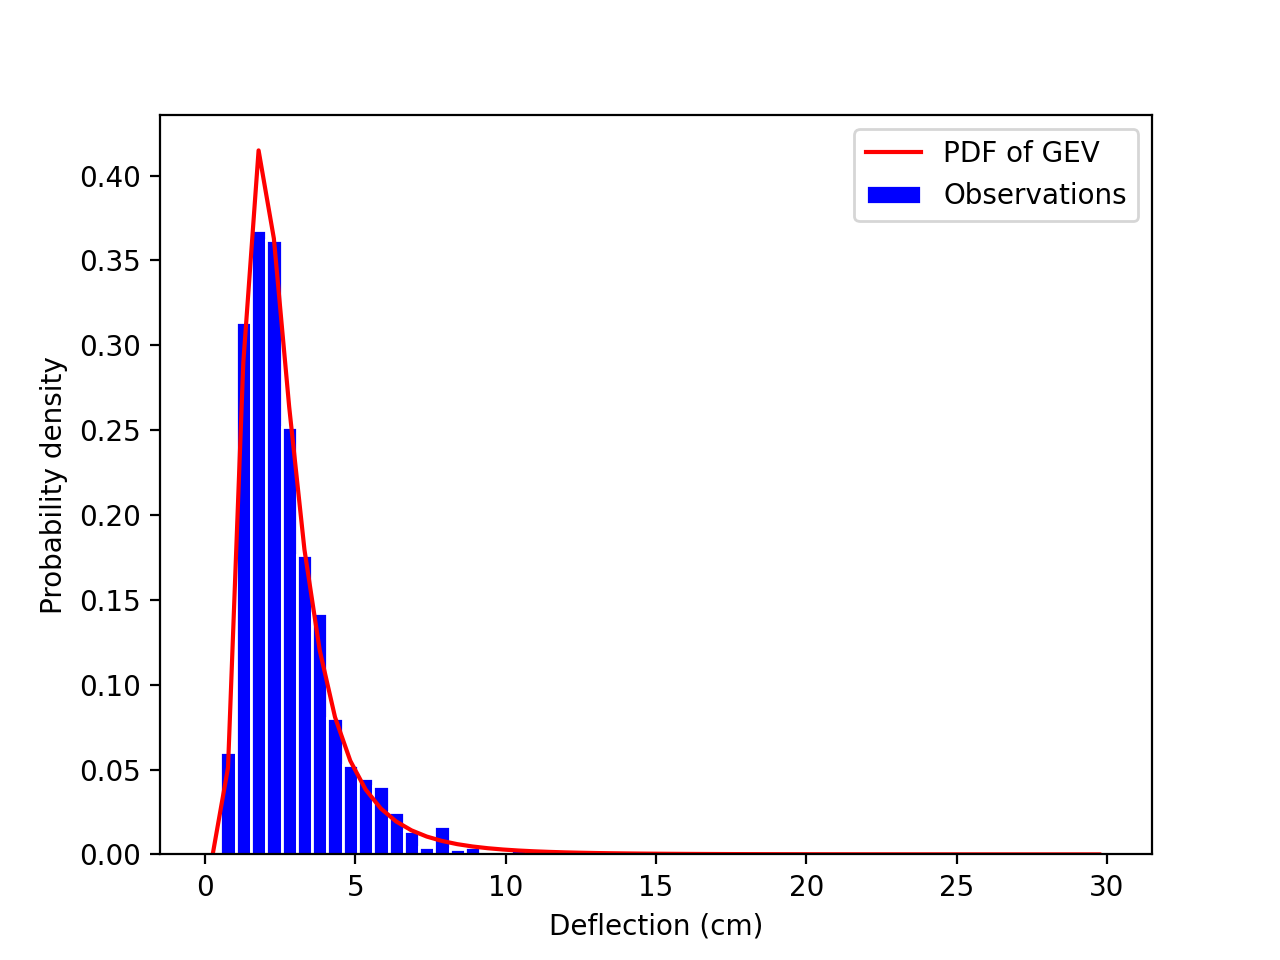

In [5]:
fig, ax1 = plt.subplots()

ax1.hist(data.deflection, bins=bins, label='Observations', color='blue', density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, gev_pdf, label="PDF of GEV", color='r')
ax1.set_xlabel('Deflection (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


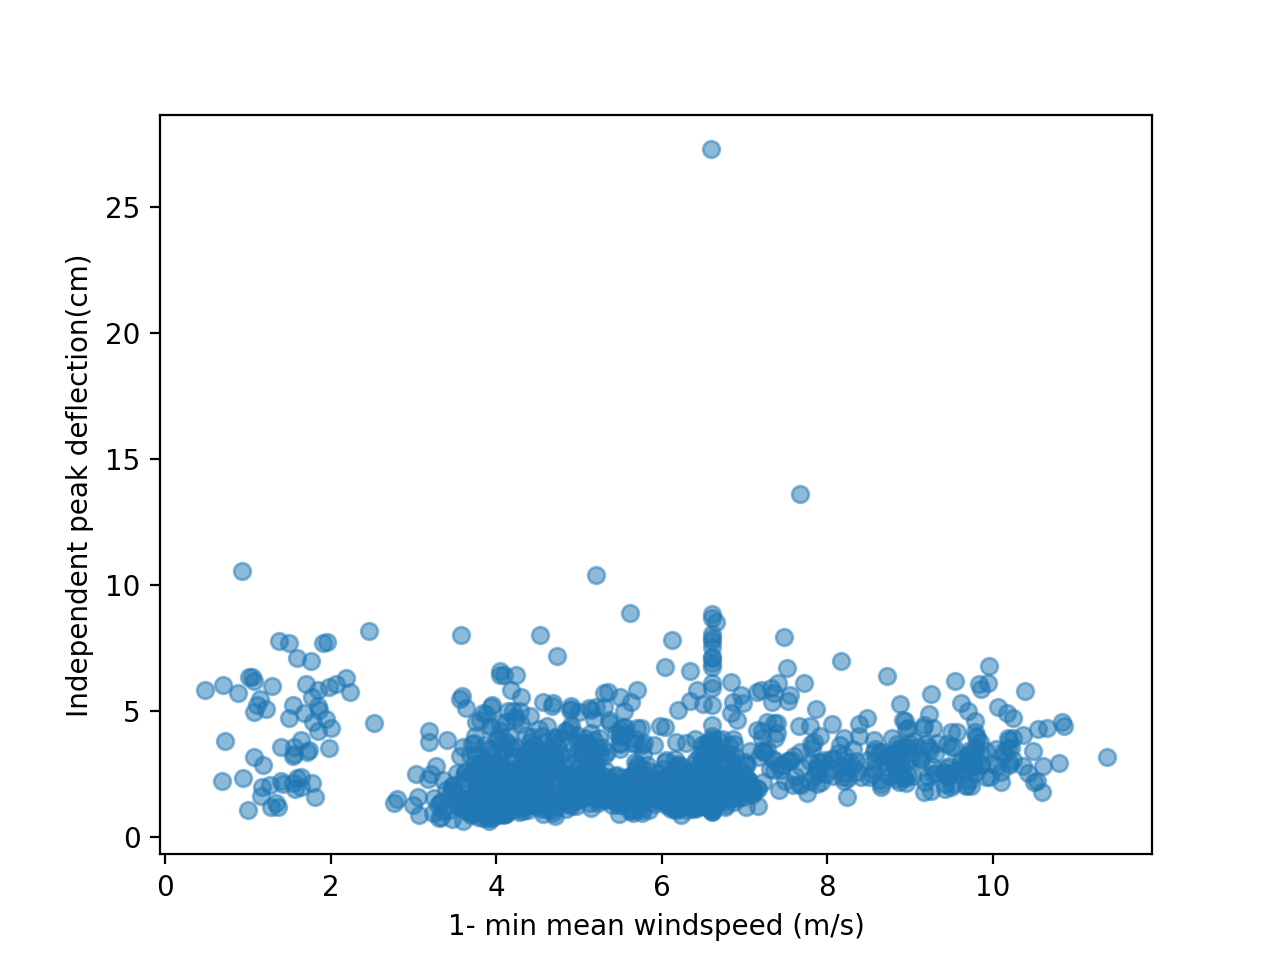

Text(0, 0.5, 'Independent peak deflection(cm)')

In [6]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.windspeed, data.deflection, alpha= 0.5)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')

In [7]:
r = np.corrcoef(data.windspeed, data.deflection)
print(r)

[[1.         0.06300516]
 [0.06300516 1.        ]]


## GEV Fit

<IPython.core.display.Javascript object>


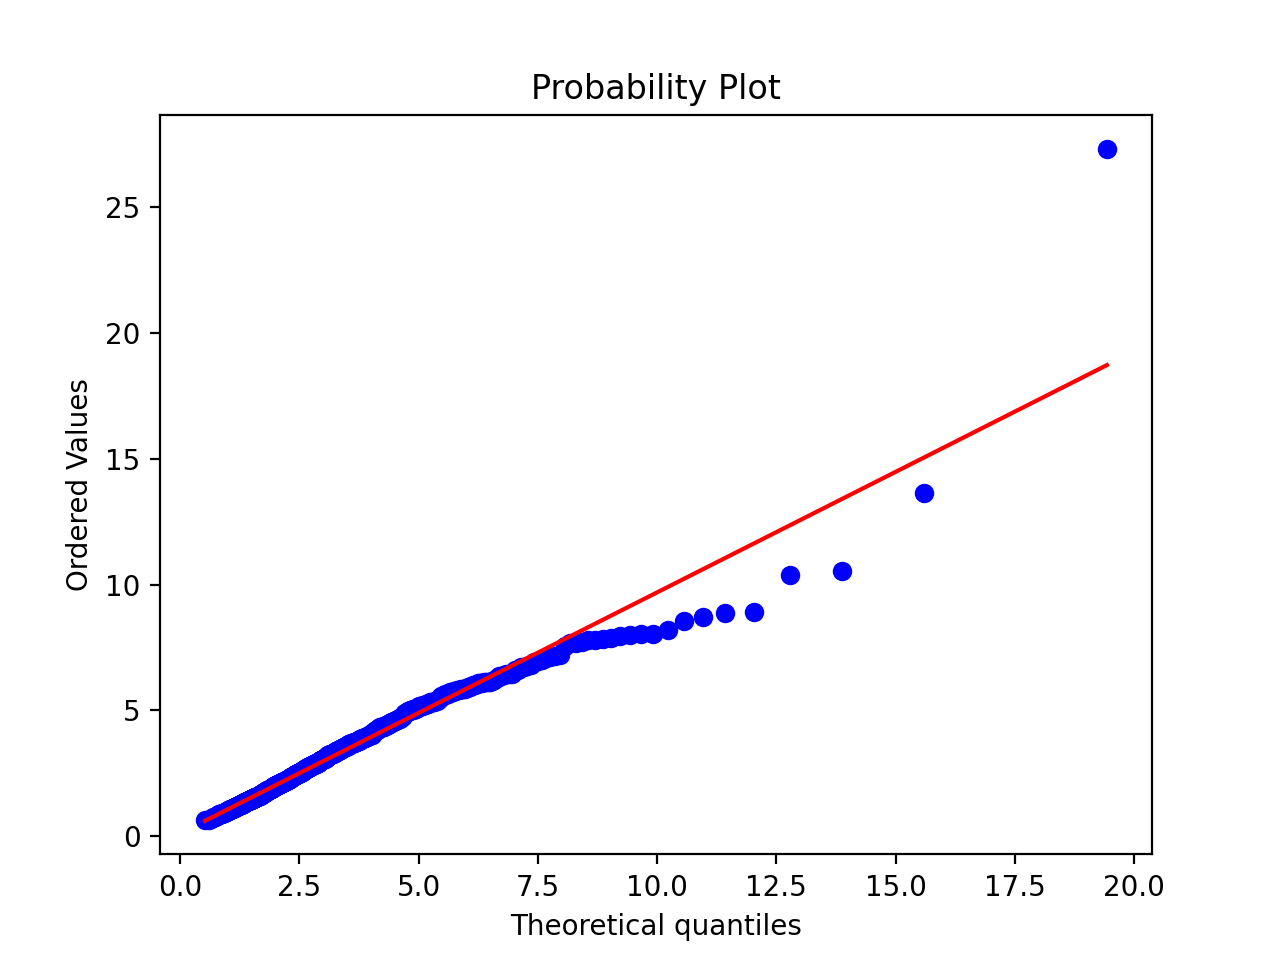

In [8]:
plt.figure()
stats.probplot(data.deflection, (gev_fit[0], gev_fit[1], gev_fit[2]), dist='genextreme', plot=pylab)
pylab.show()

In [9]:
#sm.qqplot(data.deflection, line ='45')
#plt.show()

In [10]:
#stats.kstest(data.deflection, gev_cdf, gev_fit)

# Intervals

In [11]:
# Slice the data set of deflection into intervals of the wind speed.

width_slicer = WidthOfIntervalSlicer(width=1, reference="right", min_n_points=1)
wind_slices, wind_references, wind_boundaries = width_slicer.slice_(data.windspeed)

#print(wind_boundaries)


deflection_intervals= []
for i in range (len(wind_references)):
    deflection_intervals.append([])


for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windspeed[j] >= wind_boundaries[i][0]) & (data.windspeed[j] < wind_boundaries[i][1]):
            deflection_intervals[i].append(data.deflection[j])


# Number of points per Interval
#for i in range(len(deflection_intervals)):
    #print(len(deflection_intervals[i]))

In [12]:
parameter_list= []
for i in range (len(gev_fit)):
    parameter_list.append([])

for i in range(len(deflection_intervals)):
    fit= stats.genextreme.fit(deflection_intervals[i])
    parameter_list[0].append(fit[0])
    parameter_list[1].append(fit[1])
    parameter_list[2].append(fit[2])

print(len(parameter_list[0]))

11


/Applications/anaconda3/envs/env_masterthese/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


In [13]:
# shape parameter
mean= np.mean(parameter_list[0])
print(mean)

-0.03740167782660581


<IPython.core.display.Javascript object>


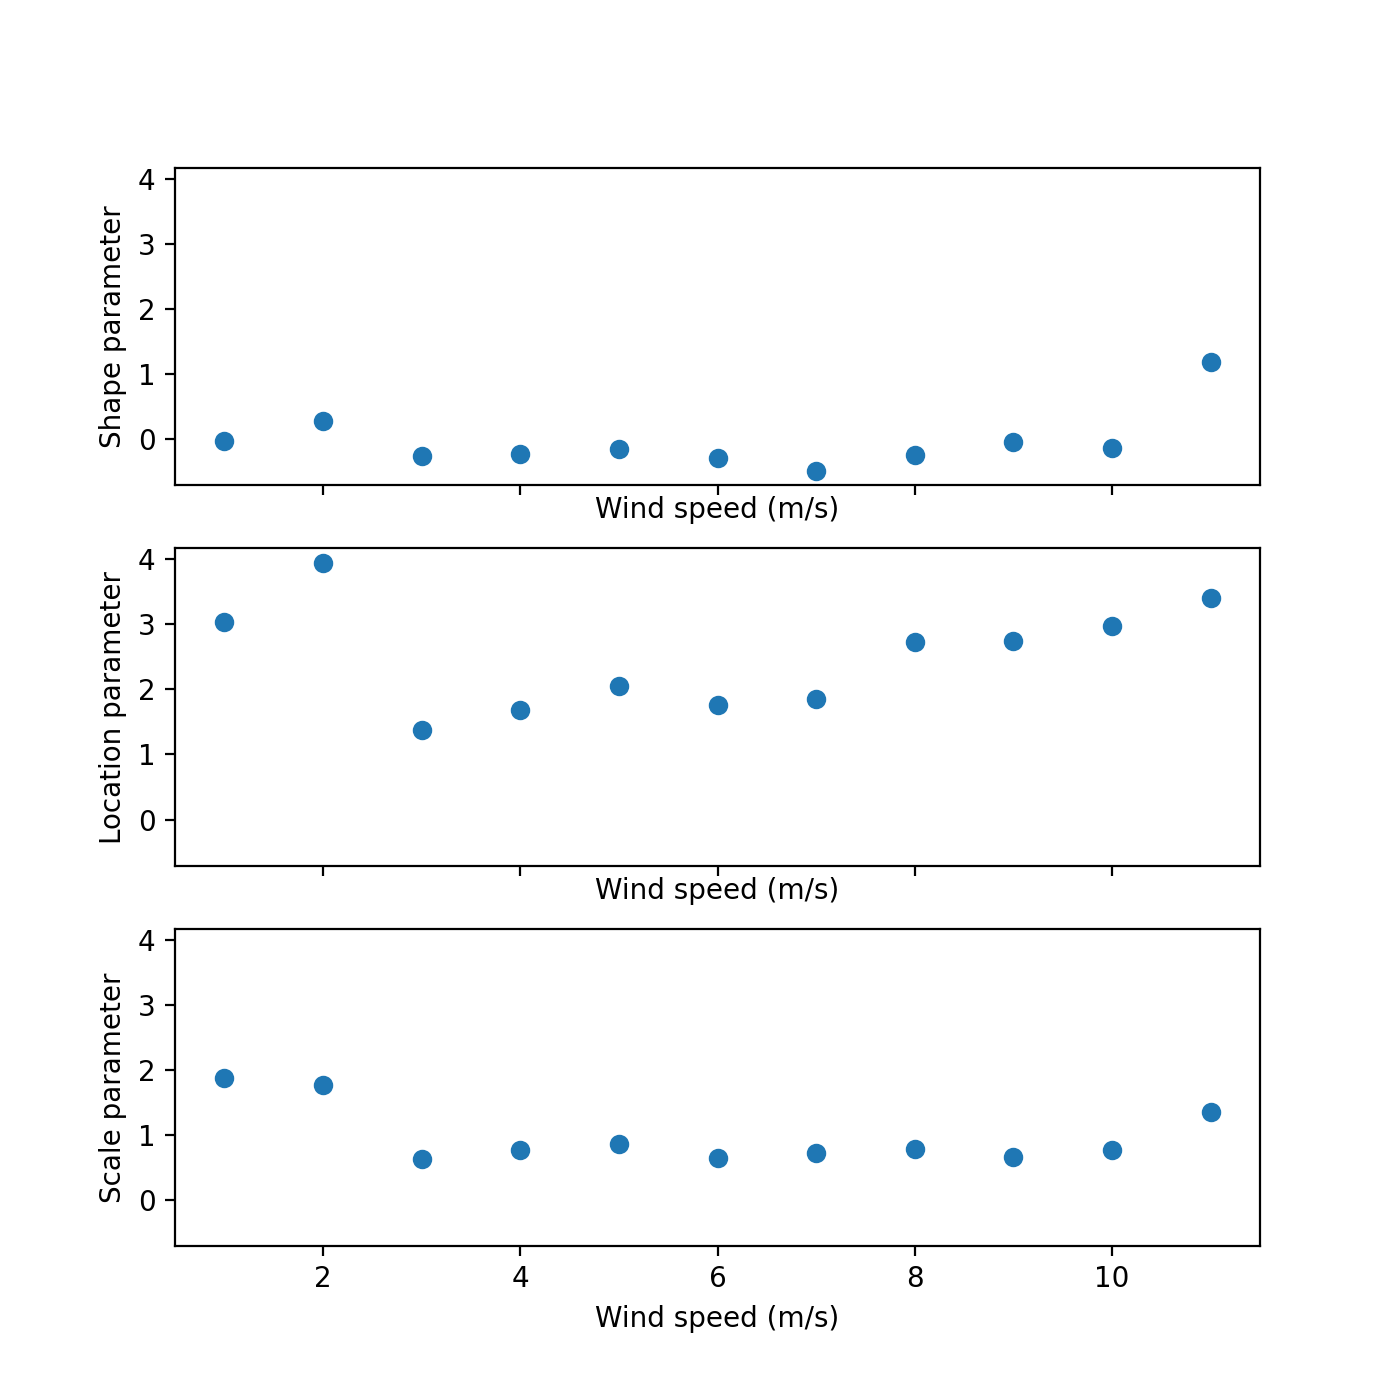

Text(0, 0.5, 'Scale parameter')

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(wind_references, parameter_list[0])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(wind_references, parameter_list[1])
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(wind_references, parameter_list[2])
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

# Dependence function of response

In [15]:
# Define dependence functions

def _power3(x, a, b, c):
    return a + b * x ** c
def _linear(x, a, b):
    return x * b + a
def _exp3(x, a, b, c):
    return a + b * np.exp(c * x)


bounds_3p = [(None, None), (None, None), (None, None)]
bounds_2p = [(None, None), (None, None)]
exp_bounds = [(0, None), (0, None), (None, None)]

power3 = DependenceFunction(_power3, bounds_3p, latex="$a + b * x^c$")
linear = DependenceFunction(_linear, latex="$a + b * x$")
exp3 = DependenceFunction(_exp3, bounds=exp_bounds)

#print(tuple(exp3.parameters.values()))
#print(tuple(linear.parameters.values()))
#print(tuple(power3.parameters.values()))

In [16]:
shape_param_fit= linear.fit(wind_references, parameter_list[0])
print(shape_param_fit)

#linear.fit(wind_references, parameter_list[0])
#print(linear)

None


In [17]:
x= np.asarray(wind_references)
y1= np.asarray(parameter_list[0])
y2= np.asarray(parameter_list[1])
y3= np.asarray(parameter_list[2])

## linear fit

In [18]:
my_linear_param1 = fit_function(linear, x, y1, (1, 1), "lsq", None, None)
my_linear_param2 = fit_function(linear, x, y2, (1, 1), "lsq", None, None)
my_linear_param3 = fit_function(linear, x, y3, (1, 1), "lsq", None, None)
print(my_linear_param1)
print(my_linear_param2)
print(my_linear_param3)

[-0.29465694  0.04287588]
[2.28382407 0.0367189 ]
[ 1.34415587 -0.05963844]


<IPython.core.display.Javascript object>


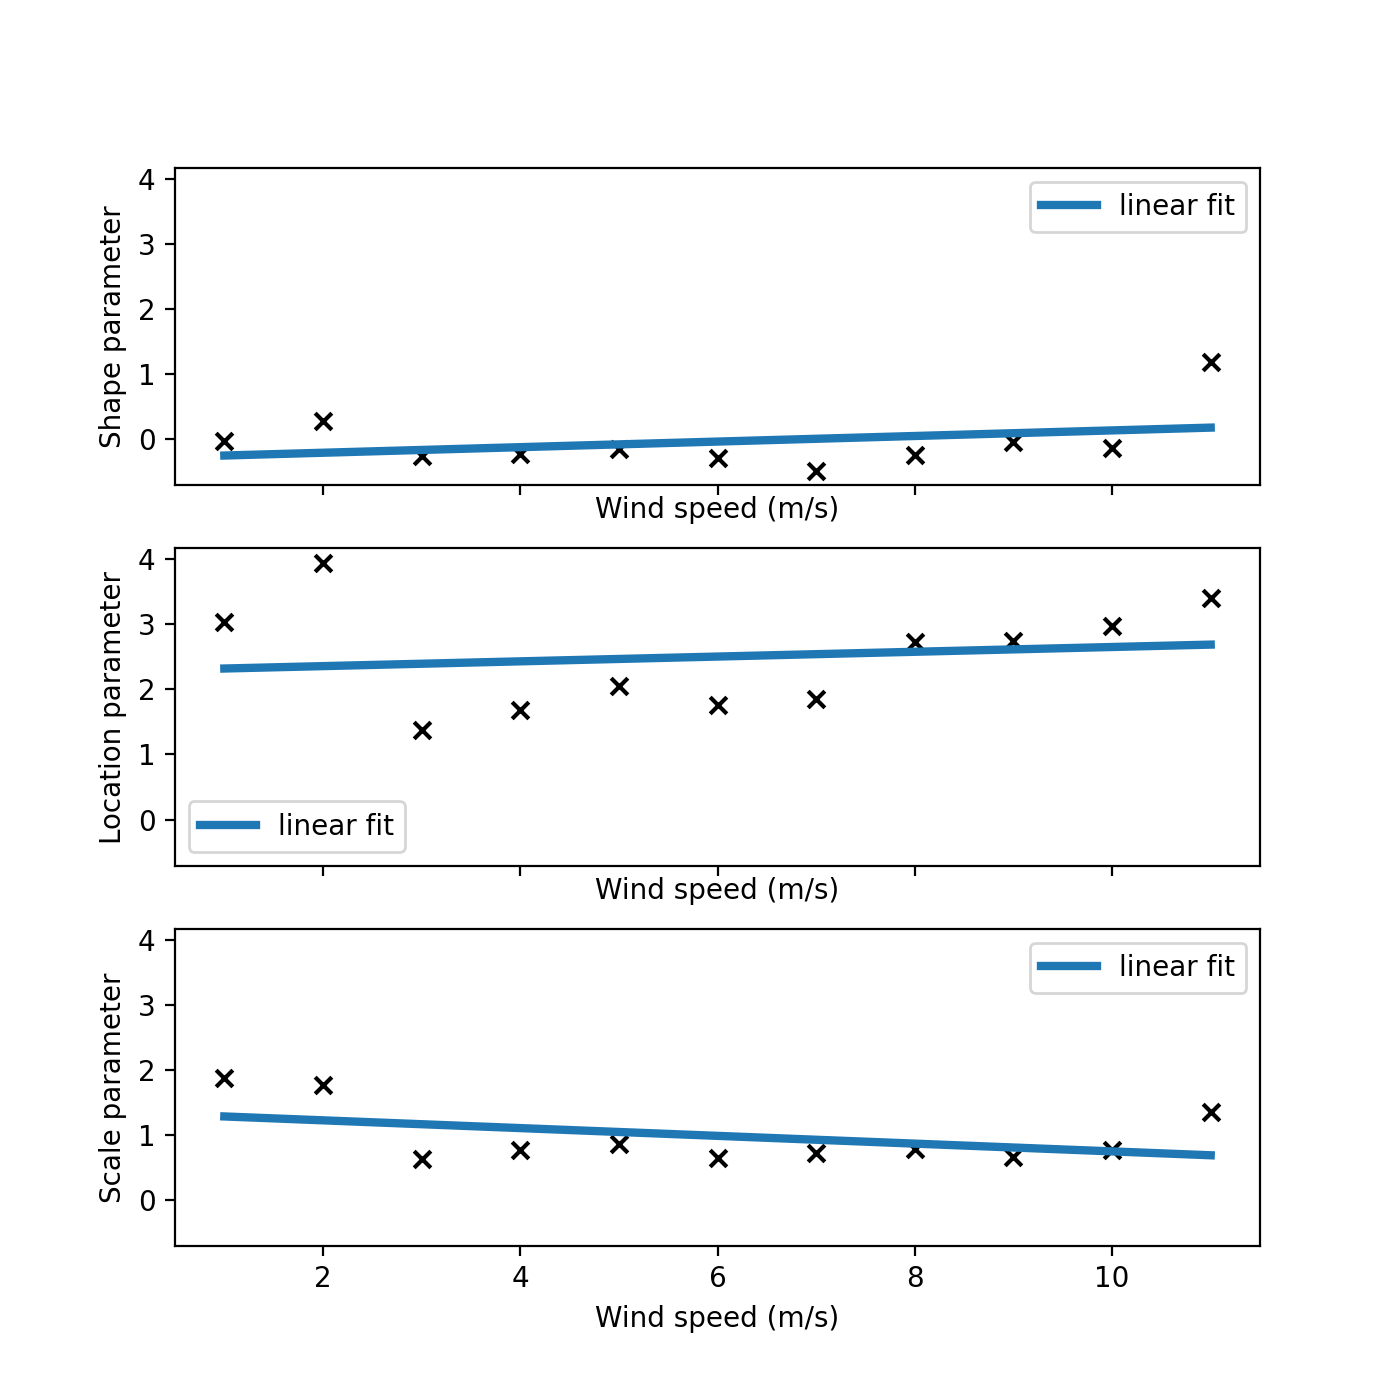

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(x, y1, marker="x", c="k")
ax1.plot(x, linear(x, *my_linear_param1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(x, y2, marker="x", c="k")
ax2.plot(x, linear(x, *my_linear_param2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(x, y3, marker="x", c="k")
ax3.plot(x, linear(x, *my_linear_param3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

In [20]:
#plt.figure()
#plt.scatter(x, y1, marker="x", c="k", label= 'shape parameter GEV')
#plt.plot(x, linear(x, *my_linear_param1), label="linear fit", linewidth=3)
#plt.xlabel('Wind speed (m/s)')
#plt.ylabel('Values of shape parameter GEV')
#plt.legend()

In [21]:
#plt.figure()
#plt.scatter(x, y2, marker="x", c="k", label= 'location parameter GEV')
#plt.plot(x, linear(x, *my_linear_param2), label="linear fit", linewidth=3)
#plt.xlabel('Wind speed (m/s)')
#plt.ylabel('Values of location parameter GEV')
#plt.legend()

In [22]:
#plt.figure()
#plt.scatter(x, y3, marker="x", c="k", label= 'scale parameter GEV')
#plt.plot(x, linear(x, *my_linear_param3), label="linear fit", linewidth=3)
#plt.xlabel('Wind speed (m/s)')
#plt.ylabel('Values of scale parameter GEV')
#plt.legend()

## exponential fit

In [23]:
exp_p0 = tuple(exp3.parameters.values())
my_exp_param1 = fit_function(exp3, x, y1, exp_p0, "lsq", exp3.bounds)
my_exp_param2 = fit_function(exp3, x, y2, exp_p0, "lsq", exp3.bounds)
my_exp_param3 = fit_function(exp3, x, y3, exp_p0, "lsq", exp3.bounds)
print(my_exp_param1)
print(my_exp_param2)
print(my_exp_param3)

[ 3.24995916e-09  1.15876737e-02 -2.96024061e+01]
[2.29398975e+00 4.16952490e-04 7.23366505e-01]
[ 0.79350974  2.69887749 -0.82080146]


<IPython.core.display.Javascript object>


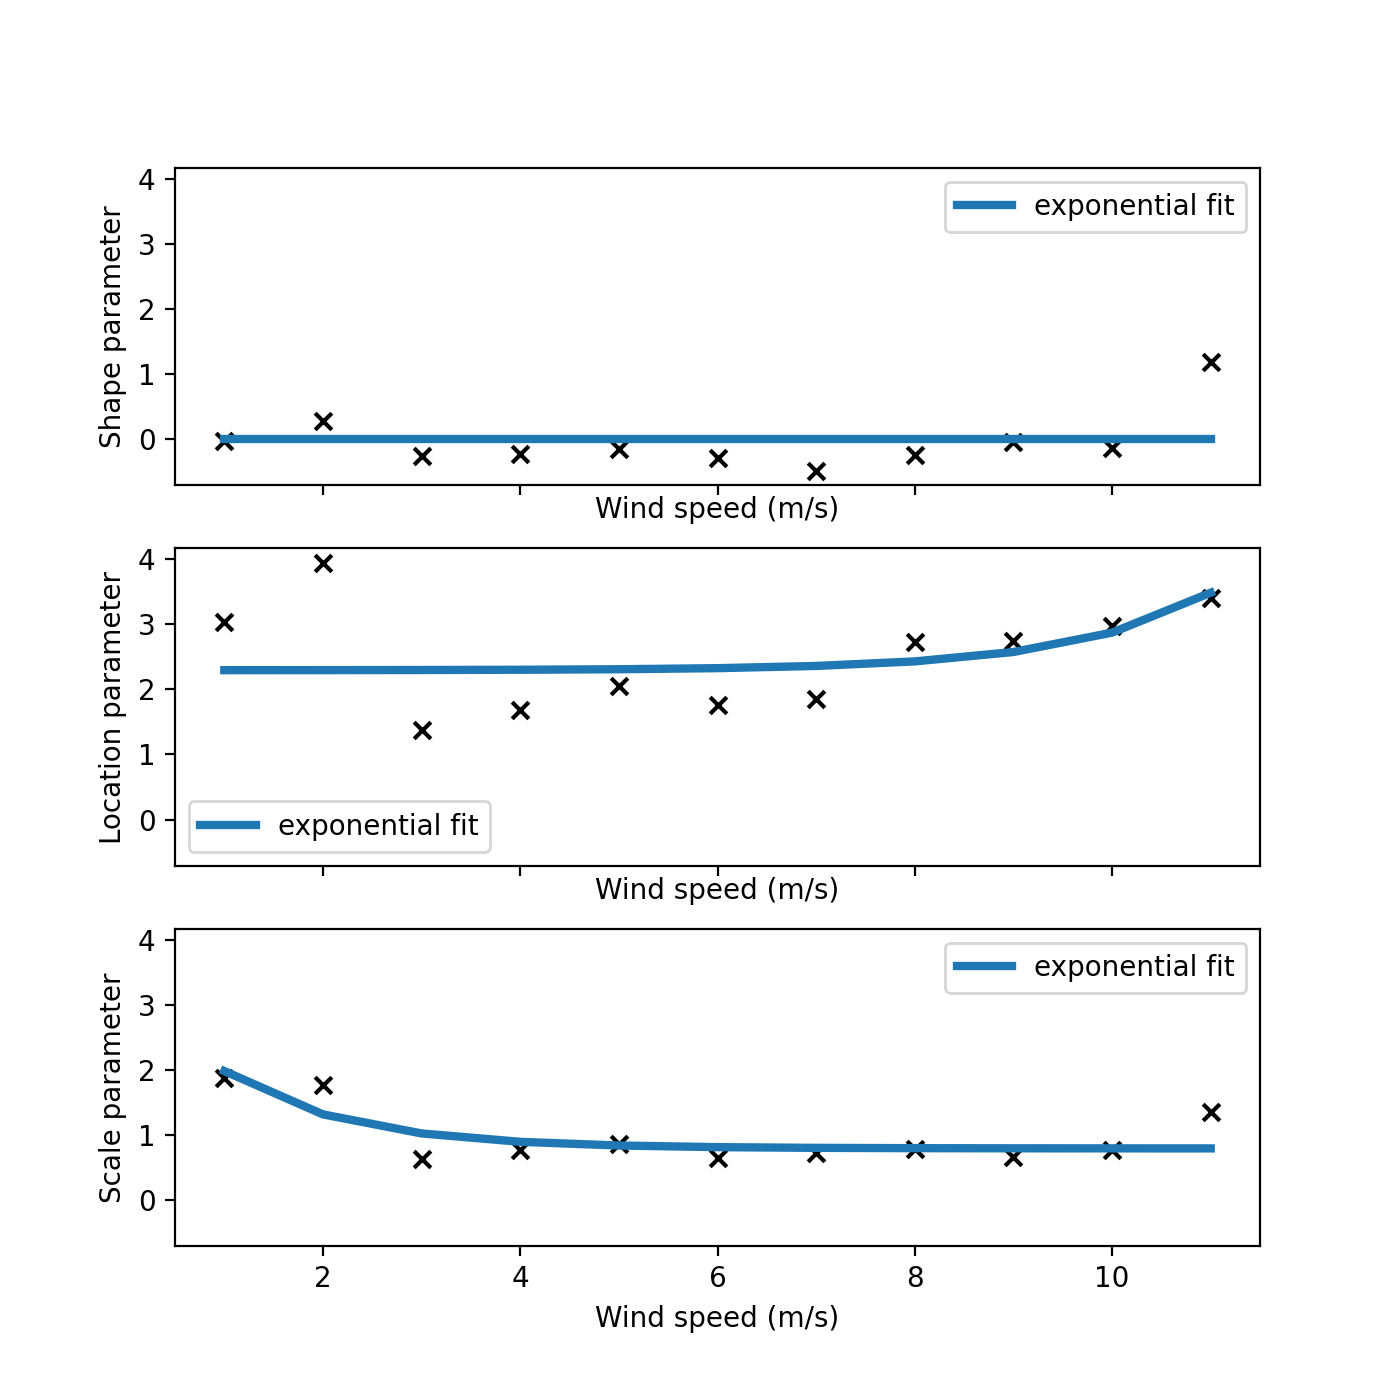

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(x, y1, marker="x", c="k")
ax1.plot(x, exp3(x, *my_exp_param1), label="exponential fit", linewidth=3)
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(x, y2, marker="x", c="k")
ax2.plot(x, exp3(x, *my_exp_param2), label="exponential fit", linewidth=3)
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(x, y3, marker="x", c="k")
ax3.plot(x, exp3(x, *my_exp_param3), label="exponential fit", linewidth=3)
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

<IPython.core.display.Javascript object>


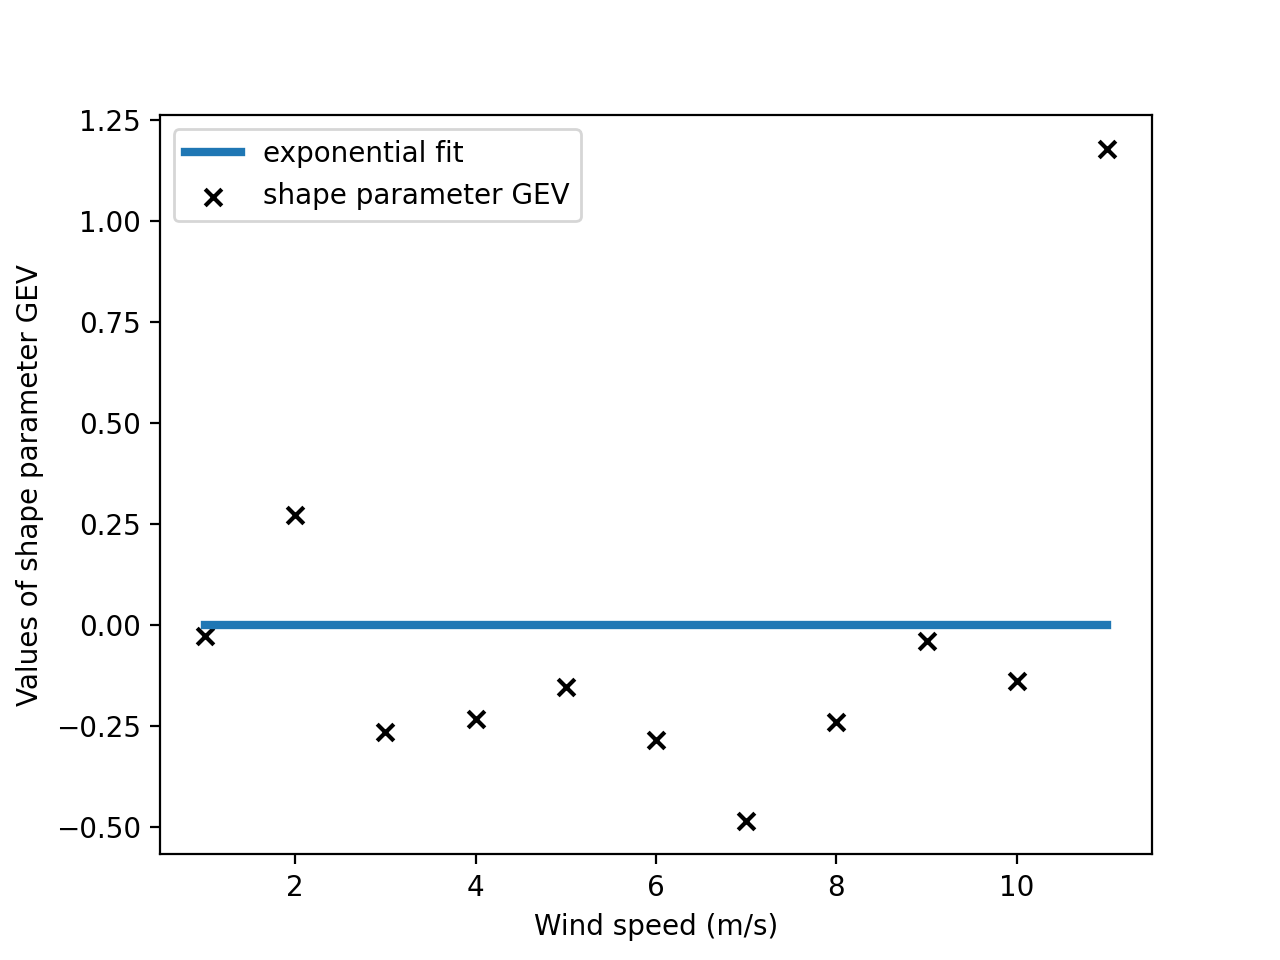

In [25]:
plt.figure()
plt.scatter(x, y1, marker="x", c="k", label= 'shape parameter GEV')
plt.plot(x, exp3(x, *my_exp_param1), label="exponential fit", linewidth=3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Values of shape parameter GEV')
plt.legend()

<IPython.core.display.Javascript object>


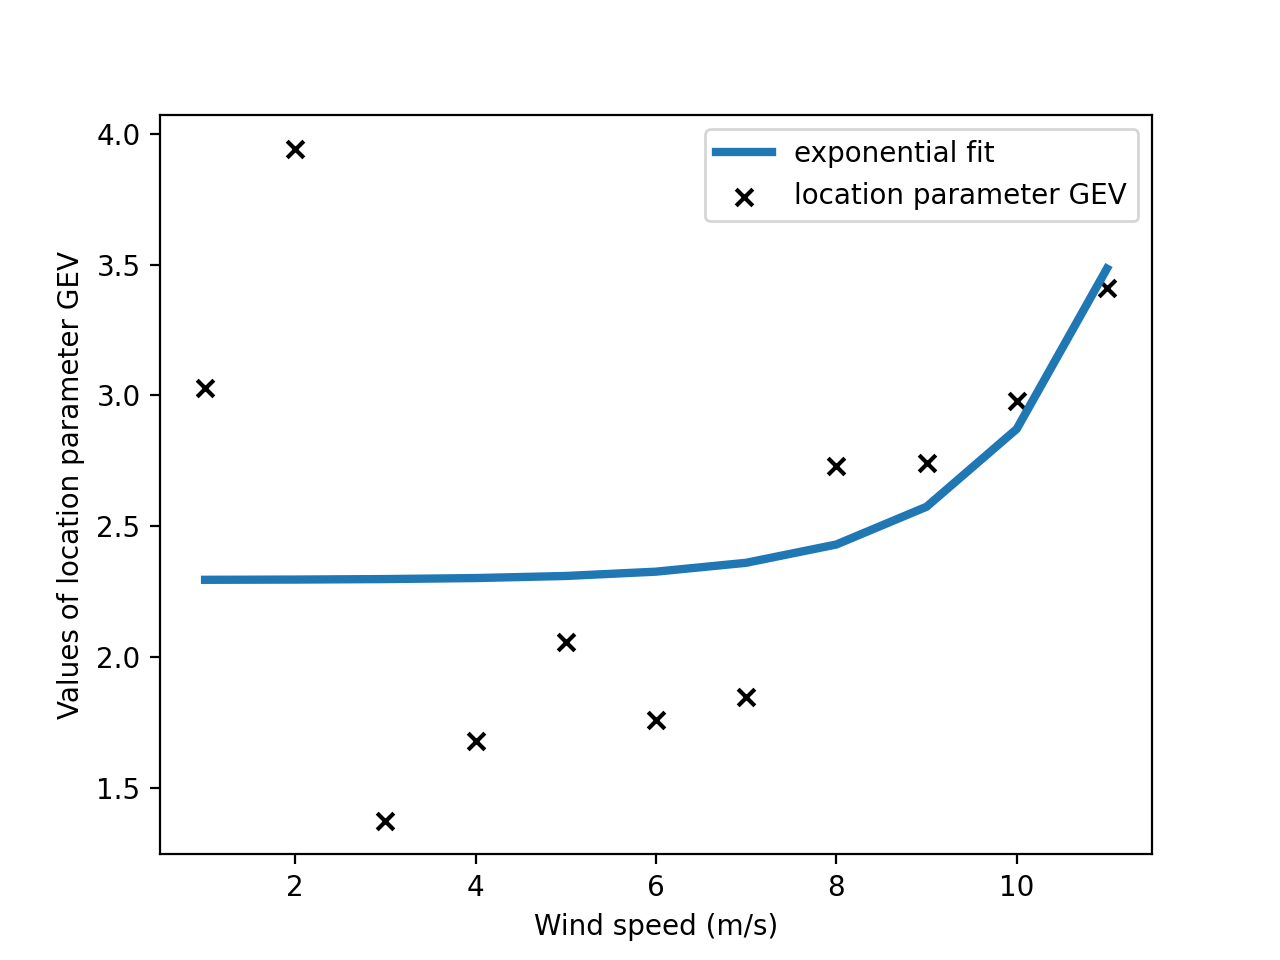

In [26]:
plt.figure()
plt.scatter(x, y2, marker="x", c="k", label= 'location parameter GEV')
plt.plot(x, exp3(x, *my_exp_param2), label="exponential fit", linewidth=3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Values of location parameter GEV')
plt.legend()

<IPython.core.display.Javascript object>


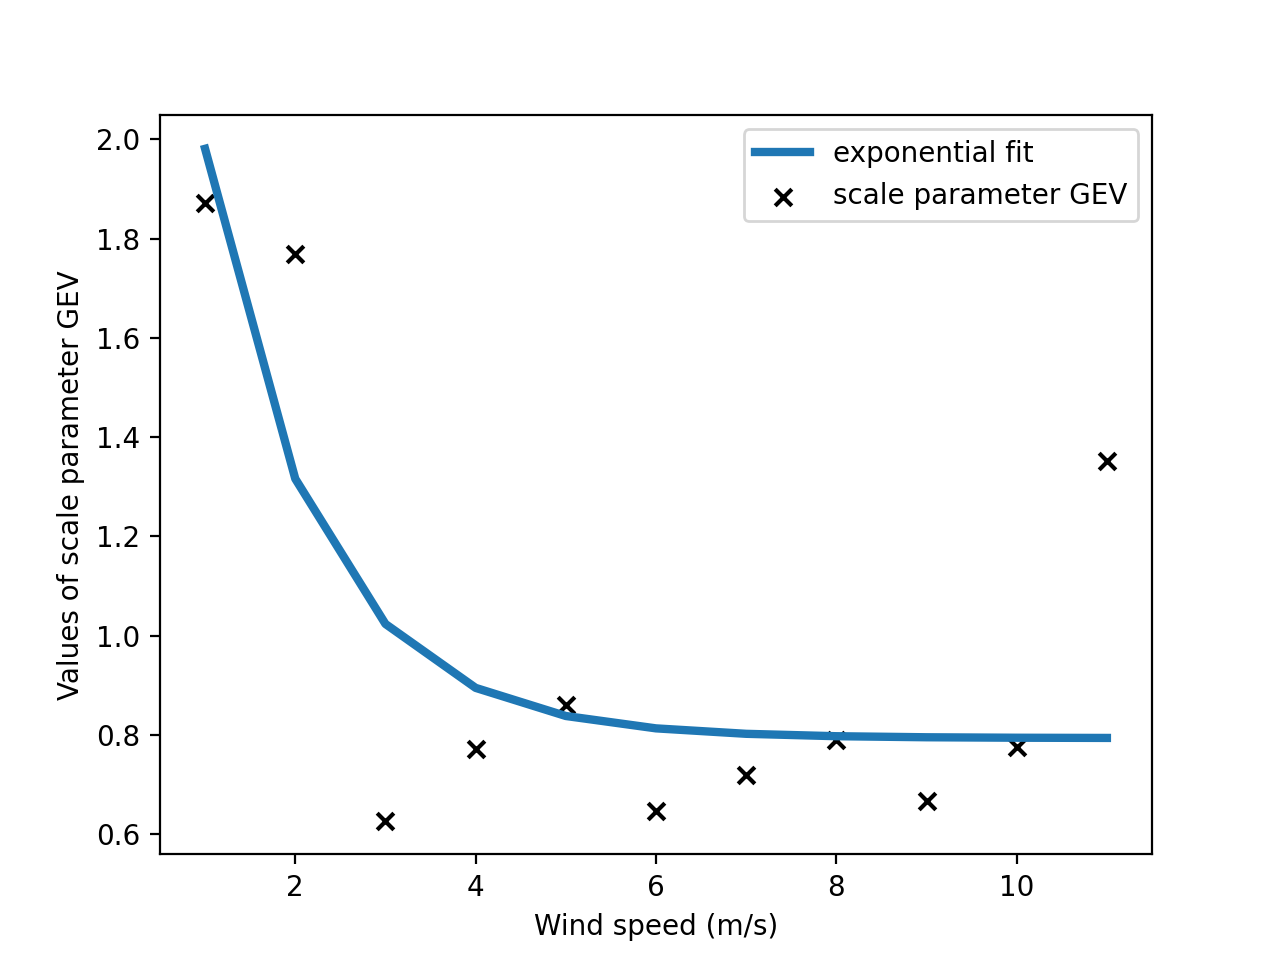

In [27]:
plt.figure()
plt.scatter(x, y3, marker="x", c="k", label= 'scale parameter GEV')
plt.plot(x, exp3(x, *my_exp_param3), label="exponential fit", linewidth=3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Values of scale parameter GEV')
plt.legend()

## power 3 fit

In [28]:
#power3_p0 = tuple(power3.parameters.values())
#my_power_param1 = fit_function(power3, x, y1, power3_p0, "lsq", power3.bounds)
#my_power_param2 = fit_function(power3, x, y2, power3_p0, "lsq", power3.bounds)
#my_power_param3 = fit_function(power3, x, y3, power3_p0, "lsq", power3.bounds)
#print(my_power_param1)
#print(my_power_param2)
#print(my_power_param3)

# Alternative Dependency

In [29]:
#mean_absolute_error(data.deflection,)
#Korrelationskoeffizient
# Intervall von 0-2 anschauen, Maxima anschauen

# Mean deflection per interval
mean_deflection = []
for i in range(len(wind_references)):
    mean_deflection.append(np.mean(deflection_intervals[i]))

# Min deflection per interval
min_deflection = []
for i in range(len(wind_references)):
    min_deflection.append(min(deflection_intervals[i]))
    
r_min = np.corrcoef(min_deflection, wind_references)
print(r_min)

[[1.         0.63999206]
 [0.63999206 1.        ]]


<IPython.core.display.Javascript object>


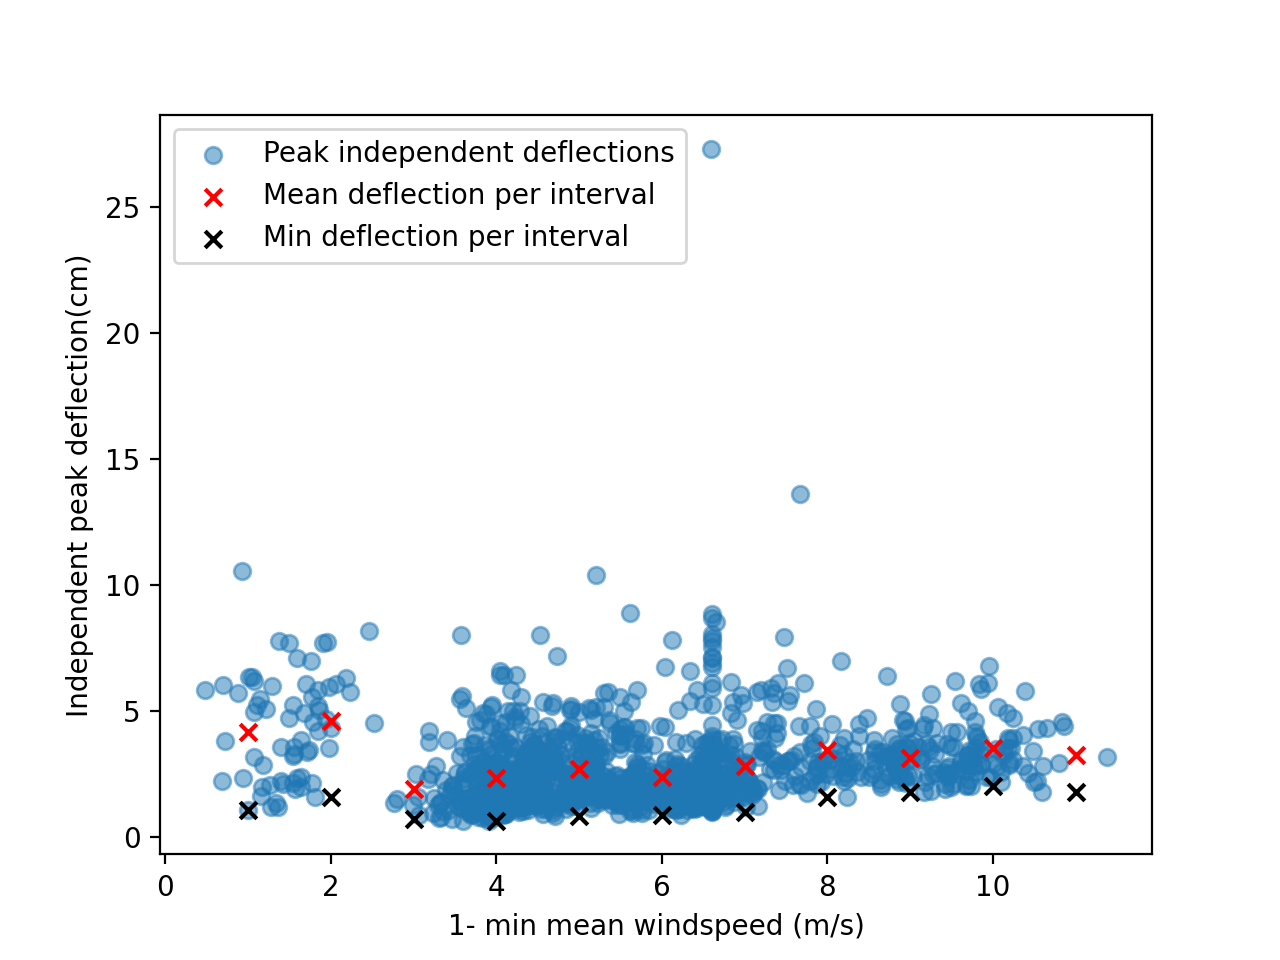

In [30]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.windspeed, data.deflection, alpha= 0.5, label='Peak independent deflections')
ax1.scatter(wind_references, mean_deflection, marker="x", c="r", label='Mean deflection per interval')
ax1.scatter(wind_references, min_deflection, marker="x", c="k", label='Min deflection per interval')
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
ax1.legend()

# Joint Model

In [31]:
# Wind speed.
dist_description_0 = {
    "distribution": ExponentiatedWeibullDistribution(),
    "intervals": WidthOfIntervalSlicer(2, min_n_points=10),
}
# Deflection.
dist_description_1 = {
    "distribution": WeibullDistribution(),
    "conditional_on": 0,
    "parameters": {"alpha": linear, "beta": linear, "gamma": linear},
}

In [32]:
model = GlobalHierarchicalModel([dist_description_0, dist_description_1])
model.fit(data)
print(model)

GlobalHierarchicalModel(distributions=[ExponentiatedWeibullDistribution(alpha=6.2292216813237244, beta=2.8808699979472103, delta=1.1191451283467646), ConditionalWeibullDistribution(alpha=DependenceFunction(func=_linear, a=0.5314914185867898, b=0.08867837324154704), beta=DependenceFunction(func=_linear, a=0.5314914185867898, b=0.08867837324154704), gamma=DependenceFunction(func=_linear, a=0.5314914185867898, b=0.08867837324154704))], conditional_on=[None, 0])


In [33]:
#plot_dependence_functions(model)

In [34]:
#model_sample= model.draw_sample(100)